In [1]:
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
from time import time
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import numpy as np
import holidays
import calendar

%matplotlib inline

In [2]:
df = pickle.load(open('../pickles/2015_2016_taxis.pkl', 'rb'))
taxi_zone_key = pd.read_csv('../taxi_project/taxi_zones_selected.csv')
neighbs = list(taxi_zone_key.LocationID)
df = df[df['pickup_taxizone_id'].isin(neighbs)].reset_index()
df = df.drop(['index'],axis=1)

In [3]:
print(df.shape)
df.head()

(467331, 5)


,pickup_datetime,pickup_taxizone_id,rides,sum_fares,borough
0,2016-04-01,4.0,74,1285.21,Manhattan
1,2016-04-01,12.0,2,46.05,Manhattan
2,2016-04-01,13.0,52,934.69,Manhattan
3,2016-04-01,24.0,32,459.65,Manhattan
4,2016-04-01,43.0,72,1381.41,Manhattan


In [4]:
neighbs = taxi_zone_key[['LocationID','Zone']].to_dict()
neighb_key = {neighbs['LocationID'][m]: neighbs['Zone'][m] for m in neighbs['LocationID'].keys()}

In [5]:
#Add label for each neighborhood
t0 = time()
df['neighb'] = df.apply(lambda row: neighb_key[row['pickup_taxizone_id']], axis = 1)
print((time()-t0)/60, 'minutes')
df.head()

0.795602810382843 minutes


,pickup_datetime,pickup_taxizone_id,rides,sum_fares,borough,neighb
0,2016-04-01,4.0,74,1285.21,Manhattan,Alphabet City
1,2016-04-01,12.0,2,46.05,Manhattan,Battery Park
2,2016-04-01,13.0,52,934.69,Manhattan,Battery Park City
3,2016-04-01,24.0,32,459.65,Manhattan,Bloomingdale
4,2016-04-01,43.0,72,1381.41,Manhattan,Central Park


In [9]:
##Key for weather join(index 0), neighb types(index 1)
neighb_key = {"Alphabet City":['Lower Manhattan', 'Residential'],
'Battery Park':['Lower Manhattan', 'Park'],
'Battery Park City':['Lower Manhattan', 'Commercial'],
'Bloomingdale':['Upper Manhattan','Residential'],
'Central Park':['Upper Manhattan','Park'],
'Chinatown':['Lower Manhattan','Residential'],
'Clinton East':['Upper Manhattan','Residential'],
'Clinton West':['Upper Manhattan','Residential'],
'East Chelsea':['Lower Manhattan','Commercial_1'],
'East Village':['Lower Manhattan','Commercial_1'],
'Financial District North':['Lower Manhattan','Commercial_2'],
'Financial District South':['Lower Manhattan','Commercial_2'],
'Flatiron':['Lower Manhattan','Commercial_1'],
'Garment District':['Lower Manhattan','Commercial_1'],
'Gramercy':['Lower Manhattan','Commercial_1'],
'Greenwich Village North':['Lower Manhattan','Residential'],
'Greenwich Village South':['Lower Manhattan','Residential'],
'Hudson Sq':['Lower Manhattan','Residential'],
'JFK Airport':['JFK','Airport'],
'Kips Bay':['Lower Manhattan','Residential'],
'LaGuardia Airport':['LGA','Airport'],
'Lenox Hill East':['Upper Manhattan','Residential'],
'Lenox Hill West':['Upper Manhattan','Residential'],
'Lincoln Square East':['Upper Manhattan','Residential'],
'Lincoln Square West':['Upper Manhattan','Residential'],
'Little Italy/NoLiTa':['Lower Manhattan','Residential'],
'Lower East Side':['Lower Manhattan','Residential'],
'Manhattan Valley':['Upper Manhattan','Residential'],
'Meatpacking/West Village West':['Lower Manhattan','Residential'],
'Midtown Center':['Upper Manhattan','Commercial_2'],
'Midtown East':['Upper Manhattan','Commercial_2'],
'Midtown North':['Upper Manhattan','Commercial_2'],
'Midtown South':['Upper Manhattan','Commercial_2'],
'Murray Hill':['Upper Manhattan','Commercial_2'],
'Penn Station/Madison Sq West':['Lower Manhattan','MSG'],
'Seaport':['Lower Manhattan','Commercial_1'],
'SoHo':['Lower Manhattan','Commercial_1'],
'Stuy Town/Peter Cooper Village':['Lower Manhattan','Residential'],
'Sutton Place/Turtle Bay North':['Upper Manhattan','Residential'],
'Times Sq/Theatre District':['Upper Manhattan','Commercial_2'],
'TriBeCa/Civic Center':['Lower Manhattan','Commercial_1'],
'Two Bridges/Seward Park':['Upper Manhattan','Residential'],
'UN/Turtle Bay South':['Upper Manhattan','Commercial_1'],
'Union Sq':['Lower Manhattan','Commercial_1'],
'Upper East Side North':['Upper Manhattan','Residential'],
'Upper East Side South':['Upper Manhattan','Residential'],
'Upper West Side North':['Upper Manhattan','Residential'],
'Upper West Side South':['Upper Manhattan','Residential'],
'West Chelsea/Hudson Yards':['Lower Manhattan', 'Commercial_1'],
'West Village':['Lower Manhattan','Residential'],
'World Trade Center':['Lower Manhattan','Commercial_2'],
'Yorkville East':['Upper Manhattan','Residential'],
'Yorkville West':['Upper Manhattan','Residential'],
'Randalls Island':['Upper Manhattan','Residential'],
"Governor's Island/Ellis Island/Liberty Island":['Upper Manhattan','Residential'],}

def datetime_convert(d):
    if d.hour<23:
        return datetime(d.year,d.month,d.day,d.hour+1)
    else:
        d += timedelta(days=1)
        return datetime(d.year,d.month,d.day,0)

In [11]:
## read in weather data

t0 = time()
weather = pd.read_csv('../pickles/weather_final.csv')
weather=weather.drop(['Unnamed: 0'],axis=1)
weather['date_time'] = pd.to_datetime(weather['date_time'].str[:-6],infer_datetime_format=True)
weather['date_time'] = weather['date_time'].apply(datetime_convert)
print((time()-t0)/60, 'minutes')

0.015839405854543052 minutes


In [12]:
## merge weather data with existing dataframe
t0 = time()
df['weather_zone'] = df.apply(lambda row: neighb_key[row['neighb']][0], axis = 1)
weather = weather.rename(columns = {'zone':'weather_zone'})
df = df.rename(columns={'pickup_datetime':'date_time'})
df = pd.merge(df, weather,how = 'left', on = ['date_time','weather_zone'])
print((time()-t0)/60, 'minutes')

0.672281543413798 minutes


In [14]:
df = df.drop(['weather_zone','borough'],axis = 1)
gdf = pickle.load(open('../pickles/gdf.pkl', 'rb'))
gdf.head()

,zone,LocationID,borough,geometry,area
0,Newark Airport,1,EWR,POLYGON ((-8258175.532737532 4939590.488999957...,12.736223
1,Jamaica Bay,2,Queens,(POLYGON ((-8217980.621910957 4931402.32096114...,23.137078
2,Allerton/Pelham Gardens,3,Bronx,POLYGON ((-8220713.534155379 4965416.648662397...,5.132194
3,Alphabet City,4,Manhattan,POLYGON ((-8234500.226961649 4944099.916942869...,1.294162
4,Arden Heights,5,Staten Island,"POLYGON ((-8257036.10884249 4920241.492315316,...",8.089915


In [15]:
def day_of_week(day):
    #encodes monday-thursday, as weekday, friday, saturday, sunday individually
    m = day.weekday()
    return calendar.day_name[m]
    
def dt_month(day):
    #encodes monday-thursday, as weekday, friday, saturday, sunday individually
    m = day.month
    return calendar.month_name[m]

In [18]:
t0 = time()
#create time of year and day metrics
df['day_of_week'] = df['date_time'].apply(day_of_week)
df = pd.merge(df,gdf[['LocationID','area']], how='left', left_on='pickup_taxizone_id', right_on='LocationID')
df = df.drop(['zip_code','LocationID'],axis=1)
df['month'] = df['date_time'].apply(dt_month)
df['time_of_day'] = df.apply(lambda row: row['date_time'].strftime('%H:%M'), axis=1)
#create area controlled metrics
df['rides_per_sqkm'] = df.apply(lambda row: row['rides']/row['area'], axis=1)
df['fares_per_sqkm'] = df.apply(lambda row: row['sum_fares']/row['area'], axis=1)
df = df.drop(['area'],axiprint(df.shape)
df = df.dropna()

3.129712382952372 minutes


In [19]:
print(df.shape)
df = df.dropna()
df = df[df['sum_fares']>5]
print(df.shape)

(467391, 14)
(459908, 14)


In [22]:
#Read in events data
events = pd.read_csv('../pickles/events.csv')
events= events[['date','type']]
events['date'] = pd.to_datetime(events['date'])
events['hour'] = events.apply(lambda row: row['date'].hour, axis = 1)
events['date'] = events.apply(lambda row: datetime(row['date'].year,row['date'].month, row['date'].day, 12) if row['hour']==0 else row['date'], axis = 1)

In [24]:
#For events at Madison Square Garden I had scraped all concerts, Rangers and Knicks games.  
#With those in hand I created two columns, one indicating that an event_start, and event_end which were only applied
#to observations at Penn Station.  IE if there was a knicks game starting at 7pm on 1/26/2016, the observations 
#for that evening would be as followed:
##  Date_time             neighb                          fares_per_sqkm       event_start       event_end
##  1/26/2016 17:00:00    Penn Station/Madison Sq West     346873              none              none
##  1/26/2016 18:00:00    Penn Station/Madison Sq West     282378              bball_s           none
##  1/26/2016 19:00:00    Penn Station/Madison Sq West     253928              bball_s           none
##  1/26/2016 20:00:00    Penn Station/Madison Sq West     145083              bball_s           none
##  1/26/2016 21:00:00    Penn Station/Madison Sq West     198278              none              bball_e
##  1/26/2016 22:00:00    Penn Station/Madison Sq West     382322              none              bball_e
##  1/26/2016 23:00:00    Penn Station/Madison Sq West     201321              none              bball_e
##  1/27/2016 00:00:00    Penn Station/Madison Sq West     110678              none              none

#merge start time

start_dates = []
e_types=[]
neighbs=[]
for m in range(events.shape[0]):
    e = events.iloc[m]
    t = e['date']
    start_dates.append(datetime(t.year, t.month, t.day, t.hour-1))
    start_dates.append(datetime(t.year, t.month, t.day, t.hour))
    start_dates.append(datetime(t.year, t.month, t.day, t.hour+1))
    for m in range(3):
        e_types.append(e['type']+'_s')#tag_s for later, when this becomes a category in the dummy matrix
        neighbs.append('Penn Station/Madison Sq West')
        
start_times = pd.DataFrame({'date_time':start_dates, 'start_event':e_types, 'neighb':neighbs})


In [25]:
#merge end times
end_dates = []
e_types2=[]
neighbs=[]
for m in range(events.shape[0]):
    e = events.iloc[m]
    t = e['date']
    end_dates.append(datetime(t.year, t.month, t.day, t.hour+2))
    end_dates.append(datetime(t.year, t.month, t.day, t.hour+3))
    try:
        end_dates.append(datetime(t.year, t.month, t.day, t.hour+4))
    except:
        t += timedelta(days=1)
        end_dates.append(datetime(t.year, t.month, t.day, 0))
    for m in range(3):
        e_types2.append(e['type']+'_e')
        neighbs.append('Penn Station/Madison Sq West')

end_times = pd.DataFrame({'date_time':end_dates, 'end_event':e_types2,'neighb':neighbs})

In [26]:
df = pd.merge(df, end_times, how='left', left_on=['date_time','neighb'], right_on=['date_time','neighb'])
df['end_event'] = df['end_event'].fillna(value='None_s')

df = pd.merge(df, start_times, how='left', left_on=['date_time','neighb'], right_on=['date_time','neighb'])
df['start_event'] = df['start_event'].fillna(value='None_e')

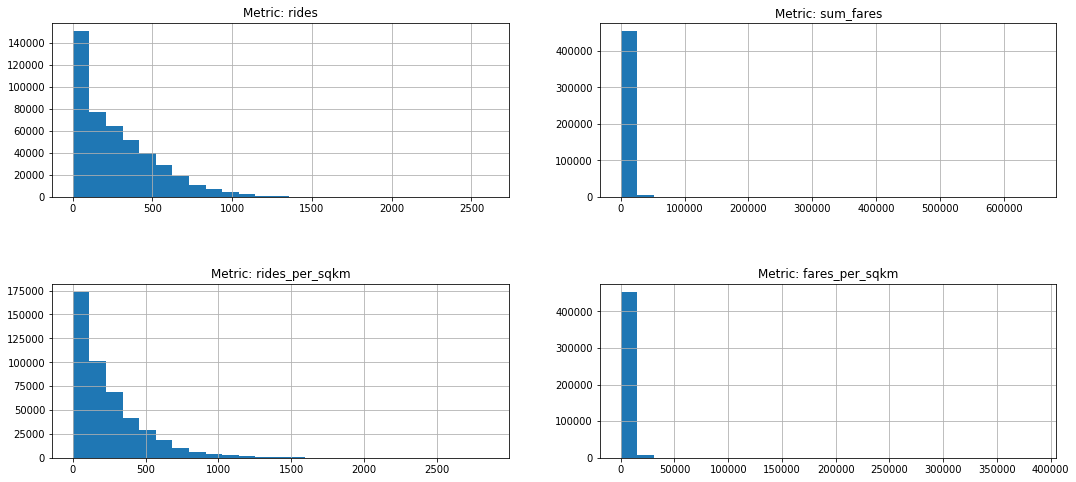

In [27]:
columns = ['rides', 'sum_fares','rides_per_sqkm','fares_per_sqkm']
fig, axarr = plt.subplots(2, 2,figsize=(18,8))
fig.subplots_adjust(hspace=.5)

i = 0
j = 0
for column in columns:
    df[column].hist(bins = 25, ax =axarr[i,j])
    axarr[i,j].set_title('Metric: %s' % column)
    j += 1
    if j == 2:
        j = 0
        i += 1

In [28]:
to_remove = []
for neighb in df.neighb.unique():
    m = df[df['neighb']==neighb].rides.mean()
    if m<5:
        print(neighb, df[df['neighb']==neighb].rides.mean())
        print(df[df['neighb']==neighb].rides_per_sqkm.mean())
        print ('------------------------')
        to_remove.append(neighb)

neighbs=list(df.neighb.unique())

for n in to_remove:
    neighbs.remove(n)
df = df[df['neighb'].isin(neighbs)]

df = df.reset_index(drop=True)

Randalls Island 2.04053109713
0.538030322777
------------------------
Governor's Island/Ellis Island/Liberty Island 1.28571428571
6.710506574
------------------------


In [29]:
us_holidays = holidays.UnitedStates()

df['holiday'] = df.apply(lambda row: 'holiday' if (row['date_time'] in us_holidays) else 'not_holiday', axis=1)

In [31]:
with open('../pickles/df_2015_16.pkl','wb') as f:
    pickle.dump(df, f)

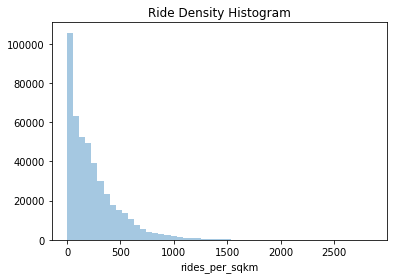

In [32]:
ax = sns.distplot(df['rides_per_sqkm'],kde=False)
ax.set_title('Ride Density Histogram')
plt.savefig('rides_hist.pdf')